# Programa Ingenias+ Data Science

## Objetivo del proyecto

Predecir si una persona tendra un IMC anormal o no, en base a sus habitos y/o condiciones socioeconomicas

## Objetivo del notebook

Este notebook tiene como objetivo probar diferentes algoritmos de clasificacion para determinar cual puede brindarnos mejores parametros


## Importacion archivos y librerias

In [109]:
# imports de librerias y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from utils.codificaciones import *
from utils.funcions import *

In [13]:
# importo mi csv
friesgo = pd.read_csv('datasets/friesgo.csv')

# Preprocesado

Codificando las variables categoricas y eliminando los nan

In [35]:
# Primero busco cuales columnas efectivamente son categoricas y cuales numericas
variables_categoricas = ['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','consumo_sal'
                           ,'colesterol_alto','freq_cons_alc','es_diabetico','mantiene_ha_alta']
variables_numericas = ['edad','media_fv_diaria','imc_numerico']

In [36]:
# Creo una bd codificada a pesar de que ya esten codificados (para probar si algo cambia)
friesgo_cod = friesgo.copy()

In [37]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,226,0.84%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


In [38]:
friesgo_cod = friesgo_cod.dropna()

In [39]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,0,0.0%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


In [40]:
friesgo_cod.shape

(25539, 16)

In [41]:
# Codifico las columnas
le = LabelEncoder()
for columnas in variables_categoricas:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [42]:
friesgo_cod.mantiene_ha_alta.unique()

array([1, 0], dtype=int64)

In [43]:
friesgo_cod.shape

(25539, 16)

**Por ultimo, se realiza la division del modelo en train-test**

In [44]:
# Division del dataset en train-test en este caso el tamaño de la muestra sera del 30%
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Analisis modelos

## Modelo 1: Random Forest

In [79]:
# Como realice el preprocesado en la primera seccion, voy a crear un pipeline solo con el clasificador
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42,criterion= 'gini'))
])

In [101]:
# Creare tambien un diccionario con parametros para Gridsearch, que me ayudara a buscar los mejores parametros para mi modelo de modo mas rapido/automatizado
parametros = {
    'classifier__n_estimators': [150,200],
    'classifier__max_depth': [8,10],
    'classifier__min_samples_split': [2,4],
    'classifier__min_samples_leaf': [1] 
}

In [102]:
# Creo mi GridSearchCV
grid_search = GridSearchCV(pipeline, parametros, scoring='roc_auc',return_train_score = True,)

In [103]:
# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [8, 10],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [150, 200]},
             return_train_score=True, scoring='roc_auc')

In [105]:
#Guardo el modelo encontrado por gridsearch y que pude probar con mi notebook(sin que tarde 15min+)
mejor_modelo = grid_search.best_estimator_

In [107]:
mejor_modelo

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=4,
                                        n_estimators=200, random_state=42))])

In [108]:
# Finalmente, evaluo el modelo viendo que tan bien predice mi variable objetivo, evaluandolo con el conjunto de datos de testeo
y_pred = mejor_modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.50      0.58      2901
           1       0.74      0.85      0.79      4761

    accuracy                           0.72      7662
   macro avg       0.71      0.68      0.68      7662
weighted avg       0.71      0.72      0.71      7662



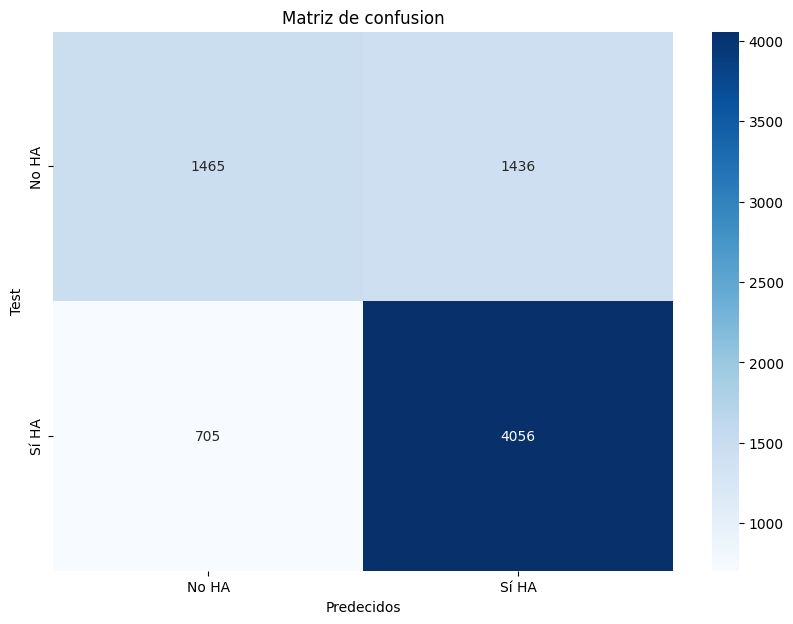

In [112]:
# Ahora de manera grafica con una matriz de confusion
matriz_conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', xticklabels=['No HA', 'Sí HA'], yticklabels=['No HA', 'Sí HA'])
plt.xlabel('Predecidos')
plt.ylabel('Test')
plt.title('Matriz de confusion')
plt.show()

In [133]:
mejor_modelo.steps[0][1].feature_importances_

array([0.07442734, 0.04869944, 0.01991653, 0.01264889, 0.2992866 ,
       0.0410063 , 0.02198615, 0.0238842 , 0.01925029, 0.04879052,
       0.05963766, 0.08142568, 0.03405057, 0.03998054, 0.17500931])

## Modelo 2

## Modelo 3